In [2]:
# !pip install -q efficientnet

In [3]:
import os
import gc
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
from IPython.display import SVG
import efficientnet.tfkeras as efn
from keras.utils import plot_model
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.applications import DenseNet121

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)
tf.random.set_seed(0)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Load the data and define hyperparameters

In [4]:
EPOCHS = 20
SAMPLE_LEN = 100
IMAGE_PATH = "../input/plant-pathology-2020-fgvc7/images/"
TEST_PATH = "../input/plant-pathology-2020-fgvc7/test.csv"
TRAIN_PATH = "../input/plant-pathology-2020-fgvc7/train.csv"
SUB_PATH = "../input/plant-pathology-2020-fgvc7/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

In [5]:
train_data.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [6]:
test_data.head()

image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

### Load sample images

In [7]:
def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(IMAGE_PATH + file_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = train_data["image_id"][:SAMPLE_LEN].progress_apply(load_image)

100%|██████████| 100/100 [00:04<00:00, 22.13it/s]


## Visualize one leaf <a id="1.2"></a>

### Sample image

In [8]:
fig = px.imshow(cv2.resize(train_images[0], (205, 136)))
fig.show()

## Channel distributions <a id="1.3"></a>

In [9]:
red_values = [np.mean(train_images[idx][:, :, 0]) for idx in range(len(train_images))]
green_values = [np.mean(train_images[idx][:, :, 1]) for idx in range(len(train_images))]
blue_values = [np.mean(train_images[idx][:, :, 2]) for idx in range(len(train_images))]
values = [np.mean(train_images[idx]) for idx in range(len(train_images))]

### All channel values

In [10]:
fig = ff.create_distplot([values], group_labels=["Channels"], colors=["purple"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

The channel values seem to have a roughly normal distribution centered around 105. The maximum channel activation is 255. This means that the average channel value is less than half the maximum value, which indicates that channels are minimally activated most of the time.

### Red channel values

In [11]:
fig = ff.create_distplot([red_values], group_labels=["R"], colors=["red"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of red channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

The red channel values seem to roughly normal distribution, but with a slight rightward (positive skew). This indicates that the red channel tends to be more concentrated at lower values, at around 100. There is large variation in average red values across images.

### Green channel values

In [12]:
fig = ff.create_distplot([green_values], group_labels=["G"], colors=["green"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of green channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

The green channel values have a more uniform distribution than the red channel values, with a smaller peak. The distribution also has a leftward skew (in contrast to red) and a larger mode of around 140. This indicates that green is more pronounced in these images than red, which makes sense, because these are images of leaves!

### Blue channel values

In [13]:
fig = ff.create_distplot([blue_values], group_labels=["B"], colors=["blue"])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of blue channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig

The blue channel has the most uniform distribution out of the three color channels, with minimal skew (slight leftward skew). The blue channel shows great variation across images in the dataset.

### All channel values (together)

In [14]:
fig = go.Figure()

for idx, values in enumerate([red_values, green_values, blue_values]):
    if idx == 0:
        color = "Red"
    if idx == 1:
        color = "Green"
    if idx == 2:
        color = "Blue"
    fig.add_trace(go.Box(x=[color]*len(values), y=values, name=color, marker=dict(color=color.lower())))
    
fig.update_layout(yaxis_title="Mean value", xaxis_title="Color channel",
                  title="Mean value vs. Color channel", template="plotly_white")

In [15]:
fig = ff.create_distplot([red_values, green_values, blue_values],
                         group_labels=["R", "G", "B"],
                         colors=["red", "green", "blue"])
fig.update_layout(title_text="Distribution of red channel values", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig.data[2].marker.line.color = 'rgb(0, 0, 0)'
fig.data[2].marker.line.width = 0.5
fig

From the above plots, we can clearly see which colors are more common and which ones less common in the leaf images. Green is the most pronounced color, followed by red and blue respectively. The distributions, when plotted together, appear to have a similar shape, but shifted horizontally. 

## Visualize sample leaves <a id="1.4"></a>

Now, I will visualize sample leaves beloning to different categories in the dataset.

In [16]:
def visualize_leaves(cond=[0, 0, 0, 0], cond_cols=["healthy"], is_cond=True):
    if not is_cond:
        cols, rows = 3, min([3, len(train_images)//3])
        fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(30, rows*20/3))
        for col in range(cols):
            for row in range(rows):
                ax[row, col].imshow(train_images.loc[train_images.index[-row*3-col-1]])
        return None
        
    cond_0 = "healthy == {}".format(cond[0])
    cond_1 = "scab == {}".format(cond[1])
    cond_2 = "rust == {}".format(cond[2])
    cond_3 = "multiple_diseases == {}".format(cond[3])
    
    cond_list = []
    for col in cond_cols:
        if col == "healthy":
            cond_list.append(cond_0)
        if col == "scab":
            cond_list.append(cond_1)
        if col == "rust":
            cond_list.append(cond_2)
        if col == "multiple_diseases":
            cond_list.append(cond_3)
    
    data = train_data.loc[:100]
    for cond in cond_list:
        data = data.query(cond)
        
    images = train_images.loc[list(data.index)]
    cols, rows = 3, min([3, len(images)//3])
    
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(30, rows*20/3))
    for col in range(cols):
        for row in range(rows):
            ax[row, col].imshow(images.loc[images.index[row*3+col]])
    plt.show()

### Healthy leaves

In [ ]:
visualize_leaves(cond=[1, 0, 0, 0], cond_cols=["healthy"])

In the above images, we can see that the healthy leaves are completely green, do not have any brown/yellow spots or scars. Healthy leaves do not have scab or rust. 

### Leaves with scab

In [ ]:
visualize_leaves(cond=[0, 1, 0, 0], cond_cols=["scab"])

In the above images, we can see that leaves with "scab" have large brown marks and stains across the leaf. Scab is defined as "any of various plant diseases caused by fungi or bacteria and resulting in crustlike spots on fruit, leaves, or roots. The spots caused by such a disease". The brown marks across the leaf are a sign of these bacterial/fungal infections. Once diagnosed, scab can be treated using chemical or non-chemical methods.

In [ ]:
visualize_leaves(cond=[0, 0, 1, 0], cond_cols=["rust"])

### Leaves with rust

In the above images, we can see that leaves with "rust" have several brownish-yellow spots across the leaf. Rust is defined as "a disease, especially of cereals and other grasses, characterized by rust-colored pustules of spores on the affected leaf blades and sheaths and caused by any of several rust fungi". The yellow spots are a sign of infection by a special type of fungi called "rust fungi". Rust can also be treated with several chemical and non-chemical methods once diagnosed.

### Leaves with multiple diseases

In the above images, we can see that the leaves show symptoms for several diseases, including brown marks and yellow spots. These plants have more than one of the above-described diseases.

In [ ]:
visualize_leaves(cond=[0, 0, 0, 1], cond_cols=["multiple_diseases"])

## Visualize targets <a id="1.5"></a>

Now, I will visualize the labels and target data. **In all the below plots, blue represents the "desired" or "healthy" condition, and red represents the "undesired" or "unhealthy" condition.**

### All labels together (parallel plot)

In [21]:
fig = px.parallel_categories(train_data[["healthy", "scab", "rust", "multiple_diseases"]], color="healthy", color_continuous_scale="sunset",\
                             title="Parallel categories plot of targets")
fig

In the above plot, we can see the relationship between all four categories. As expected, it is impossible for a healthy leaf (<code>healthy == 1</code>) to have scab, rust, or multiple diseases. Also, every unhealthy leaf has one of either scab, rust, or multiple diseases. The frequency of each combination can be seen by hovering over the plot.

### Pie chart

In [22]:
fig = go.Figure([go.Pie(labels=train_data.columns[1:],
           values=train_data.iloc[:, 1:].sum().values)])
fig.update_layout(title_text="Pie chart of targets", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.show()

In the pie chart above, we can see that most leaves in the dataset are unhealthy (71.7%). Only 5% of plants have multiple diseases, and "rust" and "scab" occupy approximately one-third of the pie each.

### Healthy distribution

In [23]:
train_data["Healthy"] = train_data["healthy"].apply(bool).apply(str)
fig = px.histogram(train_data, x="Healthy", title="Healthy distribution", color="Healthy",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[0],
                "False": px.colors.qualitative.Plotly[1]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

We can see that there are more unhealthy (<code>healthy == 0</code>) plants than healthy (<code>healthy == 1</code>) ones. There are 1305 (72%) unhealthy plants and 516 (28%) healthy plants.

### Scab distribution

In [24]:
train_data["Scab"] = train_data["scab"].apply(bool).apply(str)
fig = px.histogram(train_data, x="Scab", color="Scab", title="Scab distribution",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[1],
                "False": px.colors.qualitative.Plotly[0]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

We can see that there are more plants without scab (<code>scab == 0</code>) than those with scab (<code>scab == 1</code>). There are 592 (33%) unhealthy plants and 1229 (67%) healthy plants. 

### Rust distribution

In [25]:
train_data["Rust"] = train_data["rust"].apply(bool).apply(str)
fig = px.histogram(train_data, x="Rust", color="Rust", title="Rust distribution",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[1],
                "False": px.colors.qualitative.Plotly[0]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

We can see that there are more plants without rust (<code>rust == 0</code>) than those with rust (<code>rust == 1</code>). There are 622 (34%) unhealthy plants and 1199 (66%) healthy plants. We can see that the "unhealthy" percentage is very similar for both rust and scab.

### Multiple diseases distribution

In [26]:
train_data["Multiple diseases"] = train_data["multiple_diseases"].apply(bool).apply(str)
fig = px.histogram(train_data, x="Multiple diseases", color="Multiple diseases", title="Multiple diseases distribution",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[1],
                "False": px.colors.qualitative.Plotly[0]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

We can see that very few leaves have multiple diseases (it is a very occurance). There are 91 (5%) unhealthy plants and 1730 (95%) healthy plants.

# Image processing and augmentation <a id="2"></a>

In [27]:
def edge_and_cut(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, 100, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))
    
    row_min = edge_coors[np.argsort([coor[0] for coor in edge_coors])[0]][0]
    row_max = edge_coors[np.argsort([coor[0] for coor in edge_coors])[-1]][0]
    col_min = edge_coors[np.argsort([coor[1] for coor in edge_coors])[0]][1]
    col_max = edge_coors[np.argsort([coor[1] for coor in edge_coors])[-1]][1]
    new_img = img[row_min:row_max, col_min:col_max]
    
    emb_img[row_min-10:row_min+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_max-10:row_max+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_min:row_max, col_min-10:col_min+10] = [255, 0, 0]
    emb_img[row_min:row_max, col_max-10:col_max+10] = [255, 0, 0]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=24)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=24)
    plt.show()

In [ ]:
edge_and_cut(train_images[3])
edge_and_cut(train_images[4])
edge_and_cut(train_images[5])

In [29]:
def invert(img):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img)
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(cv2.flip(img, 0))
    ax[1].set_title('Vertical Flip', fontsize=24)
    ax[2].imshow(cv2.flip(img, 1))
    ax[2].set_title('Horizontal Flip', fontsize=24)
    plt.show()

In [ ]:
invert(train_images[3])
invert(train_images[4])
invert(train_images[5])

We can see that the images are simply flipped. All major features in the image remain the same, but to a computer algorithm, the flipped images look completely different. These transformations can be used for data augmentation, making models more robust and accurate.

In [31]:
def conv(img):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
    kernel = np.ones((7, 7), np.float32)/25
    conv = cv2.filter2D(img, -1, kernel)
    ax[0].imshow(img)
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(conv)
    ax[1].set_title('Convolved Image', fontsize=24)
    plt.show()

In [ ]:
conv(train_images[3])
conv(train_images[4])
conv(train_images[5])

The convolution operator seems to have an apparent "sunshine" effect of the images. This may also serve the purpose of augmenting the data, thus helping to build more robust and accurate models. 

In [33]:
def blur(img):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(cv2.blur(img, (100, 100)))
    ax[1].set_title('Blurred Image', fontsize=24)
    plt.show()

In [ ]:
blur(train_images[3])
blur(train_images[4])
blur(train_images[5])

The transformation clearly blurs the image by removing detailed, low-level features, while retaining the major, high-level features. This is once again a great way to augment images and train more robust models.

# Modeling <a id="3"></a>

### Setup TPU Config

In [35]:
AUTO = tf.data.experimental.AUTOTUNE
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

BATCH_SIZE = 16 * strategy.num_replicas_in_sync
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

### Load labels and paths

In [36]:
def format_path(st):
    return GCS_DS_PATH + '/images/' + st + '.jpg'

test_paths = test_data.image_id.apply(format_path).values
train_paths = train_data.image_id.apply(format_path).values

train_labels = np.float32(train_data.loc[:, 'healthy':'scab'].values)
train_paths, valid_paths, train_labels, valid_labels =\
train_test_split(train_paths, train_labels, test_size=0.15, random_state=2020)

In [37]:
def decode_image(filename, label=None, image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

### Create Dataset objects

In [38]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

### Helper functions

In [39]:
def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

### Define hyperparameters and callbacks

In [40]:
lrfn = build_lrfn()
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

## DenseNet <a id="3.2"></a>

Densely Connected Convolutional Networks (DenseNets), are a popular CNN-based ImageNet used for a variety of applications, inclusing classification, segmentation, localization, etc. Most models before DenseNet relied solely on network depth for representational power. **Instead of drawing representational power from extremely deep or wide architectures, DenseNets exploit the potential of the network through feature reuse.** This was the main motivation behind the DenseNet architecture. Now let us train DenseNet on leaf images and evaluate its performance.

In [41]:
with strategy.scope():
    model = tf.keras.Sequential([DenseNet121(input_shape=(512, 512, 3),
                                             weights='imagenet',
                                             include_top=False),
                                 L.GlobalAveragePooling2D(),
                                 L.Dense(train_labels.shape[1],
                                         activation='softmax')])
        
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    model.summary()

29089792/29084464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 16, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


### DenseNet fundamental block

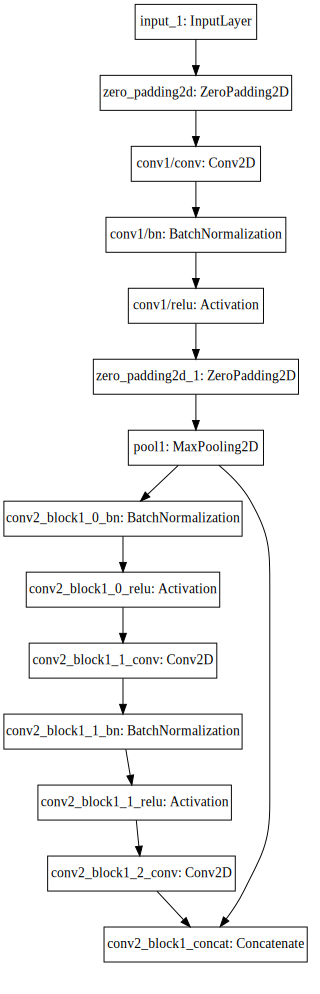

In [42]:
SVG(tf.keras.utils.model_to_dot(Model(model.layers[0].input, model.layers[0].layers[13].output), dpi=70).create(prog='dot', format='svg'))

The above image shows the fundamental block in the DenseNet architecture. The architecture mainly involves Convolution, Maxpooling, ReLU, and concatenation.

### Visualize model architecture

The model consists of the DenseNet head (without the top), followed by global average pooling and a dense layer (with softmax) to generate probabilities.

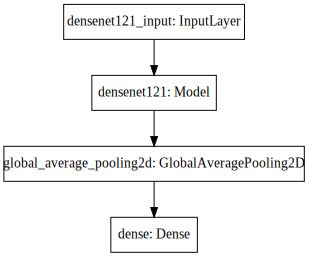

In [43]:
SVG(tf.keras.utils.model_to_dot(model, dpi=70).create(prog='dot', format='svg'))

### Train model

In [44]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=[lr_schedule],
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)

Train for 12 steps, validate for 3 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
12/12 [==============================] - 224s 19s/step - loss: 1.7287 - categorical_accuracy: 0.3561 - val_loss: 1.6749 - val_categorical_accuracy: 0.1569

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
12/12 [==============================] - 5s 379ms/step - loss: 0.9367 - categorical_accuracy: 0.6536 - val_loss: 1.1466 - val_categorical_accuracy: 0.3540

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
12/12 [==============================] - 21s 2s/step - loss: 0.3589 - categorical_accuracy: 0.8854 - val_loss: 0.6601 - val_categorical_accuracy: 0.6898

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
12/12 [==============================] - 30s 2s/step - loss: 0.2344 - categorical_accuracy: 0.9258 - val_loss: 0.4392 - val_categorical_accuracy: 0.8248

Epoch 00005: L

### Visualize results

In [45]:
def display_training_curves(training, validation, yaxis):
    if yaxis == "loss":
        ylabel = "Loss"
        title = "Loss vs. Epochs"
    else:
        ylabel = "Accuracy"
        title = "Accuracy vs. Epochs"
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Train"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Val"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()

### Scatter plots

In [46]:
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')

From the above plots, we can see that the losses decrease and accuracies increase quite consistently. The training metrics settle down very fast (after 1 or 2 epochs), whereas the validation metrics much greater volatility and start to settle down only after 7-8 epochs. This is expected because validation data is unseen and more diffcult to make predictions on than training data. 

### Animation (click ▶️)

In [47]:
acc_df = pd.DataFrame(np.transpose([[*np.arange(1, EPOCHS+1).tolist()*3], ["Train"]*EPOCHS + ["Val"]*EPOCHS + ["Benchmark"]*EPOCHS,
                                     history.history['categorical_accuracy'] + history.history['val_categorical_accuracy'] + [1.0]*EPOCHS]))
acc_df.columns = ["Epochs", "Stage", "Accuracy"]
fig = px.bar(acc_df, x="Accuracy", y="Stage", animation_frame="Epochs", title="Accuracy vs. Epochs", color='Stage',
       color_discrete_map={"Train":"dodgerblue", "Val":"darkorange", "Benchmark":"seagreen"}, orientation="h")

fig.update_layout(
    xaxis = dict(
        autorange=False,
        range=[0, 1]
    )
)

fig.update_layout(template="plotly_white")

From the animations above, we can see the volatility in validation metrics a lot more clearly. The validation metrics oscillate in an erratic fashion until it reaches the 7th epoch and starts to generalize properly.

### Sample predictions

Now, I will visualize some sample predictions made by the DenseNet model. The <font color="red">red</font> bars represent the model's prediction (maximum probability), the <font color="green">green</font> represent the ground truth (label), and the rest of the bars are <font color="blue">blue</font>. When the model predicts correctly, the prediction bar is <font color="green">green</font>.

In [48]:
def process(img):
    return cv2.resize(img/255.0, (512, 512)).reshape(-1, 512, 512, 3)
def predict(img):
    return model.layers[2](model.layers[1](model.layers[0](process(img)))).numpy()[0]

fig = make_subplots(rows=4, cols=2)
preds = predict(train_images[2])

colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Scab"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Multiple diseases"

colors[pred] = px.colors.qualitative.Plotly[1]
colors["Healthy"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[2], (205, 136))), row=1, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=1, col=2)
fig.update_layout(height=1200, width=800, title_text="DenseNet Predictions", showlegend=False)

preds = predict(train_images[0])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Multiple diseases"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[0], (205, 136))), row=2, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=2, col=2)

preds = predict(train_images[3])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Rust"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[3], (205, 136))), row=3, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=3, col=2)

preds = predict(train_images[1])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Scab"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[1], (205, 136))), row=4, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=4, col=2)

fig.update_layout(template="plotly_white")

We can see that DenseNet predicts leaf diseases with great accuracy. No red or blue bars are seen. The probabilities are very polarized (one very high and the rest very low), indicating that the model is making these predictions with great confidence.

### Generate submission

In [49]:
probs_dnn = model.predict(test_dataset, verbose=1)
sub.loc[:, 'healthy':] = probs_dnn
sub.to_csv('submission_dnn.csv', index=False)
sub.head()

15/15 [==============================] - 122s 8s/step


image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.000694           0.012652  0.986518  0.000136
1   Test_1  0.001474           0.008808  0.989553  0.000165
2   Test_2  0.000040           0.000064  0.000002  0.999894
3   Test_3  0.999595           0.000252  0.000140  0.000012
4   Test_4  0.000039           0.004251  0.995489  0.000221

## EfficientNet <a id="3.3"></a>

EfficientNet is another popular (more recent) CNN-based ImageNet model which achieved the SOTA on several image-based tasks in 2019. EfficientNet performs model scaling in an innovative way to achieve excellent accuracy with significantly fewer parameters. It achieves the same if not greater accuracy than ResNet and DenseNet with a mcuh shallower architecture. Now let us train EfficientNet on leaf images and evaluate its performance.

In [50]:
with strategy.scope():
    model = tf.keras.Sequential([efn.EfficientNetB7(input_shape=(512, 512, 3),
                                                    weights='imagenet',
                                                    include_top=False),
                                 L.GlobalAveragePooling2D(),
                                 L.Dense(train_labels.shape[1],
                                         activation='softmax')])
    
    
        
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    model.summary()

258441216/258434480 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 10244     
Total params: 64,107,924
Trainable params: 63,797,204
Non-trainable params: 310,720
_________________________________________________________________


### EfficientNet fundamental block

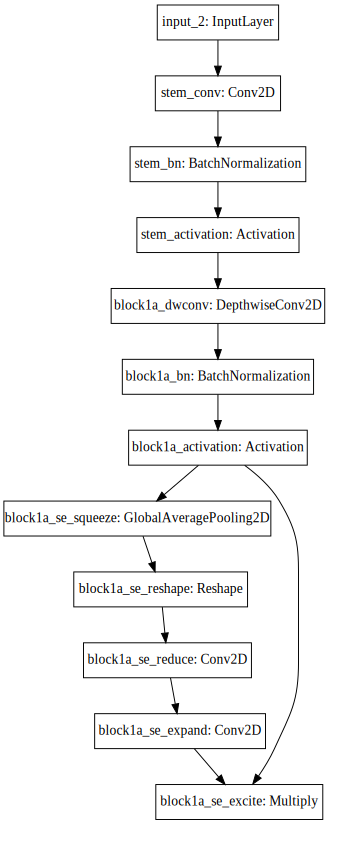

In [51]:
SVG(tf.keras.utils.model_to_dot(Model(model.layers[0].input, model.layers[0].layers[11].output), dpi=70).create(prog='dot', format='svg'))

The above image shows the fundamental block in the EfficientNet architecture. This architecture involves more addition and multiplication-based operators than DenseNet. These operations are less parameter-intensive than concatenation, which is much more common in DenseNet. Such transformations help EfficientNet achieve great efficiency (in terms of performance per parameter).

### Visualize model architecture

The model consists of the EfficientNet head (without the top), followed by global average pooling and a dense layer (with softmax) to generate probabilities.

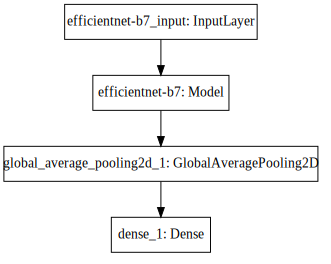

In [52]:
SVG(tf.keras.utils.model_to_dot(model, dpi=70).create(prog='dot', format='svg'))

### Train model

In [53]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=[lr_schedule],
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)

Train for 12 steps, validate for 3 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
12/12 [==============================] - 361s 30s/step - loss: 1.3727 - categorical_accuracy: 0.3040 - val_loss: 1.3246 - val_categorical_accuracy: 0.2445

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
12/12 [==============================] - 12s 982ms/step - loss: 1.1548 - categorical_accuracy: 0.6406 - val_loss: 1.1153 - val_categorical_accuracy: 0.4672

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
12/12 [==============================] - 12s 976ms/step - loss: 0.5341 - categorical_accuracy: 0.8659 - val_loss: 0.5928 - val_categorical_accuracy: 0.7628

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
12/12 [==============================] - 12s 979ms/step - loss: 0.2739 - categorical_accuracy: 0.9180 - val_loss: 0.5162 - val_categorical_accuracy: 0.8248

Epoch 0

### Visualize results

### Scatter plots

In [54]:
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')

### Animation (click ▶️)

From the above plots, we can once again see that the losses decrease and accuracies increase quite consistently. The training metrics settle down very fast (after 1 or 2 epochs). In this case, the validation metrics do not show high volatility as compared to the DenseNet model.

In [55]:
acc_df = pd.DataFrame(np.transpose([[*np.arange(1, EPOCHS+1).tolist()*3], ["Train"]*EPOCHS + ["Val"]*EPOCHS + ["Benchmark"]*EPOCHS,
                                     history.history['categorical_accuracy'] + history.history['val_categorical_accuracy'] + [1.0]*EPOCHS]))
acc_df.columns = ["Epochs", "Stage", "Accuracy"]
fig = px.bar(acc_df, x="Accuracy", y="Stage", animation_frame="Epochs", title="Accuracy vs. Epochs", color='Stage',
       color_discrete_map={"Train":"dodgerblue", "Val":"darkorange", "Benchmark":"seagreen"}, orientation="h")

fig.update_layout(
    xaxis = dict(
        autorange=False,
        range=[0, 1]
    )
)

fig.update_layout(template="plotly_white")

From the animations above, we can see that the validation and training metrics do not show great volatility. They steadily rise towards 1.0.

### Sample predictions

Now, I will visualize some sample predictions made by the EfficientNet model. The <font color="red">red</font> bars represent the model's prediction (maximum probability), the <font color="green">green</font> represent the ground truth (label), and the rest of the bars are <font color="blue">blue</font>. When the model predicts correctly, the prediction bar is <font color="green">green</font>.

In [56]:
def process(img):
    return cv2.resize(img/255.0, (512, 512)).reshape(-1, 512, 512, 3)
def predict(img):
    return model.layers[2](model.layers[1](model.layers[0](process(img)))).numpy()[0]

fig = make_subplots(rows=4, cols=2)
preds = predict(train_images[2])

colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Scab"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Multiple diseases"

colors[pred] = px.colors.qualitative.Plotly[1]
colors["Healthy"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[2], (205, 136))), row=1, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=1, col=2)
fig.update_layout(height=1200, width=800, title_text="EfficientNet Predictions", showlegend=False)

preds = predict(train_images[0])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Multiple diseases"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[0], (205, 136))), row=2, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=2, col=2)

preds = predict(train_images[3])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Rust"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[3], (205, 136))), row=3, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=3, col=2)

preds = predict(train_images[1])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Scab"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[1], (205, 136))), row=4, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=4, col=2)
fig.update_layout(template="plotly_white")

The model predicts the leaf diseases with great accuracy. The level of performance is similar to that of DenseNet, as the green bars are very common. The red and blue bars are more prominent in the last (fourth) leaf labeled "multiple diseases". This is probably because leaves with multiple diseases may show symptoms of rust and scab as well, thus slightly confusing the model.

### Generate submission

In [57]:
probs_efn = model.predict(test_dataset, verbose=1)
sub.loc[:, 'healthy':] = probs_efn
sub.to_csv('submission_efn.csv', index=False)
sub.head()

15/15 [==============================] - 57s 4s/step


image_id   healthy  multiple_diseases          rust          scab
0   Test_0  0.000506       4.924448e-05  9.994444e-01  5.626339e-07
1   Test_1  0.000037       1.109164e-04  9.996421e-01  2.105069e-04
2   Test_2  0.000002       4.419309e-06  2.744254e-08  9.999939e-01
3   Test_3  0.999873       4.623986e-08  1.272407e-04  5.033302e-08
4   Test_4  0.000443       3.728501e-04  9.988369e-01  3.470006e-04

## EfficientNet NoisyStudent <a id="3.4"></a>

EfficientNet NoisyStudent, released in 2020, is based on EfficientNet and uses semi-supervised learning on noisy images to learn rich visual representation. It outperformed EfficientNet on several tasks and is the SOTA at the time of writing (March 2020). Now let us train EfficientNet NoisyStudent on leaf images and evaluate its performance.

In [58]:
with strategy.scope():
    model = tf.keras.Sequential([efn.EfficientNetB7(input_shape=(512, 512, 3),
                                                    weights='noisy-student',
                                                    include_top=False),
                                 L.GlobalAveragePooling2D(),
                                 L.Dense(train_labels.shape[1],
                                         activation='softmax')])
    
    
        
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    model.summary()

258072576/258068648 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2560)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 10244     
Total params: 64,107,924
Trainable params: 63,797,204
Non-trainable params: 310,720
_________________________________________________________________


### EfficientNet NoisyStudent

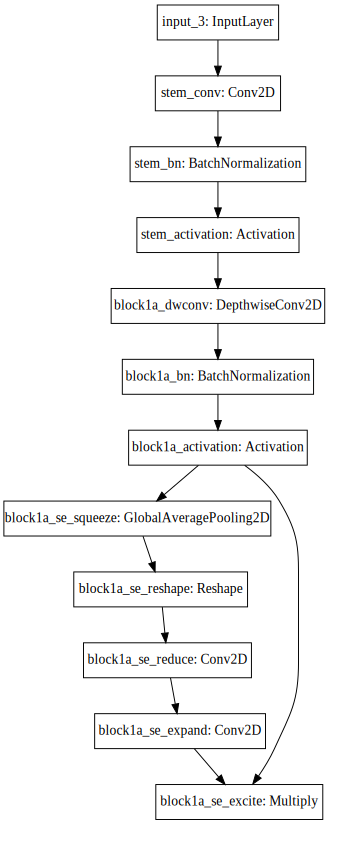

In [59]:
SVG(tf.keras.utils.model_to_dot(Model(model.layers[0].input, model.layers[0].layers[11].output), dpi=70).create(prog='dot', format='svg'))

The above image shows the fundamental block in the EfficientNet NoisyStudent architecture. This model has the same architecture as EfficientNet. Only the weights are different, as they are obtained through semi-supervision.

### Visualize model architecture

The model consists of the EfficientNet NoisyStudent head (without the top), followed by global average pooling and a dense layer (with softmax) to generate probabilities.

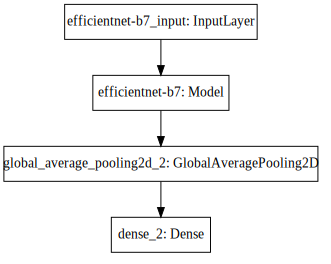

In [60]:
SVG(tf.keras.utils.model_to_dot(model, dpi=70).create(prog='dot', format='svg'))

### Train model

In [61]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=[lr_schedule],
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)

Train for 12 steps, validate for 3 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
12/12 [==============================] - 335s 28s/step - loss: 1.4069 - categorical_accuracy: 0.3060 - val_loss: 1.3025 - val_categorical_accuracy: 0.1934

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
12/12 [==============================] - 12s 980ms/step - loss: 1.2418 - categorical_accuracy: 0.4557 - val_loss: 1.2782 - val_categorical_accuracy: 0.1022

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
12/12 [==============================] - 12s 974ms/step - loss: 0.9302 - categorical_accuracy: 0.7285 - val_loss: 0.7525 - val_categorical_accuracy: 0.6715

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
12/12 [==============================] - 12s 985ms/step - loss: 0.4431 - categorical_accuracy: 0.8750 - val_loss: 0.6879 - val_categorical_accuracy: 0.7372

Epoch 0

### Visualize results

### Scatter plots

In [62]:
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')

From the above plots, we can see that the losses decrease and accuracies increase quite consistently. The training metrics settle down very fast (after 1 or 2 epochs), whereas the validation metrics much greater volatility and start to settle down only after 12-13 epochs (similar to DenseNet). This is expected because validation data is unseen and more diffcult to make predictions on than training data. 

### Animation (click ▶️)

In [63]:
acc_df = pd.DataFrame(np.transpose([[*np.arange(1, EPOCHS+1).tolist()*3], ["Train"]*EPOCHS + ["Val"]*EPOCHS + ["Benchmark"]*EPOCHS,
                                     history.history['categorical_accuracy'] + history.history['val_categorical_accuracy'] + [1.0]*EPOCHS]))
acc_df.columns = ["Epochs", "Stage", "Accuracy"]
fig = px.bar(acc_df, x="Accuracy", y="Stage", animation_frame="Epochs", title="Accuracy vs. Epochs", color='Stage',
       color_discrete_map={"Train":"dodgerblue", "Val":"darkorange", "Benchmark":"seagreen"}, orientation="h")

fig.update_layout(
    xaxis = dict(
        autorange=False,
        range=[0, 1]
    )
)

fig.update_layout(template="plotly_white")

From the animations above, we can see the volatility in validation metrics a lot more clearly. The validation metrics oscillate in an erratic fashion until it reaches the 12th epoch and starts to generalize properly.

### Sample predictions

Now, I will visualize some sample predictions made by the EfficientNet NoisyStudent model. The <font color="red">red</font> bars represent the model's prediction (maximum probability), the <font color="green">green</font> represent the ground truth (label), and the rest of the bars are <font color="blue">blue</font>. When the model predicts correctly, the prediction bar is <font color="green">green</font>.

In [64]:
def process(img):
    return cv2.resize(img/255.0, (512, 512)).reshape(-1, 512, 512, 3)
def predict(img):
    return model.layers[2](model.layers[1](model.layers[0](process(img)))).numpy()[0]

fig = make_subplots(rows=4, cols=2)
preds = predict(train_images[2])

colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Scab"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Multiple diseases"

colors[pred] = px.colors.qualitative.Plotly[1]
colors["Healthy"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[2], (205, 136))), row=1, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=1, col=2)
fig.update_layout(height=1200, width=800, title_text="EfficientNet NoisyStudent Predictions", showlegend=False)

preds = predict(train_images[0])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Multiple diseases"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[0], (205, 136))), row=2, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=2, col=2)

preds = predict(train_images[3])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Rust"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[3], (205, 136))), row=3, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=3, col=2)

preds = predict(train_images[1])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Scab"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[1], (205, 136))), row=4, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=4, col=2)
fig.update_layout(template="plotly_white")

Similar to the DenseNet model, EfficientNet NoisyStudent predicts leaf diseases with great accuracy. No red bars are seen. The probabilities are very polarized (one very high and the rest very low), indicating that the model is making these predictions with great confidence. The semi-supervised weights seem to set this model apart from EfficientNet. The red and blue bars are, once again, more prominent in the last (fourth) leaf labeled "multiple_diseases". This is probably because leaves with multiple diseases may show symptoms of rust and scab as well, thus slightly confusing the model.

### Generate submission

In [65]:
probs_efnns = model.predict(test_dataset, verbose=1)
sub.loc[:, 'healthy':] = probs_efnns
sub.to_csv('submission_efnns.csv', index=False)
sub.head()

15/15 [==============================] - 59s 4s/step


image_id   healthy  multiple_diseases          rust      scab
0   Test_0  0.000320           0.003853  9.956252e-01  0.000201
1   Test_1  0.000005           0.002484  9.972956e-01  0.000215
2   Test_2  0.000040           0.000028  5.631968e-07  0.999931
3   Test_3  0.999966           0.000006  2.112290e-05  0.000007
4   Test_4  0.000189           0.004586  9.939193e-01  0.001305

## Ensembling <a id="3.5"></a>

Ensembling involves the averaging of multiple prediction vectos to reduce errors and improve accuracy. Now, I will ensemble predictions from DenseNet and EfficientNet to (hopefully) produce better results.

In [66]:
ensemble_1, ensemble_2, ensemble_3 = [sub]*3

ensemble_1.loc[:, 'healthy':] = 0.50*probs_dnn + 0.50*probs_efn
ensemble_2.loc[:, 'healthy':] = 0.25*probs_dnn + 0.75*probs_efn
ensemble_3.loc[:, 'healthy':] = 0.75*probs_dnn + 0.25*probs_efn

ensemble_1.to_csv('submission_ensemble_1.csv', index=False)
ensemble_2.to_csv('submission_ensemble_2.csv', index=False)
ensemble_3.to_csv('submission_ensemble_3.csv', index=False)

# Takeaways <a id="4"></a>

1. Image processing and augmentation methods such as edge detection, depth estimation, flipping, etc can be used to build  models.

2. Several pretrained models like DenseNet and EfficientNet can be used to classify leaf diseases with high accuracy.

3. Ensembling, stacking, and strong validation techniques may lead to more accurate and robust models.

# Ending note <a id="5"></a>

<font color="red" size=4>This concludes my kernel. Please upvote if you like it. It motivates me to produce more quality content :)</font>